# Prior checks

We want to fully understand the location of the priors on $P$ and $i$, and make sure that we are actually obtaining prior information beyond this space.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('poster')
sns.set_palette('colorblind')
import pandas as pd
import astropy.units as u

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

## Set up priors

In [3]:
mu_xsplit = 0.75
sigma_xsplit = 0.75

npts = 10000

In [4]:
np.random.seed(11)
xsplit = np.random.lognormal(np.log(mu_xsplit), sigma_xsplit, size=npts)
cosi = np.random.uniform(0, 1, size=npts)
i = np.arccos(cosi)
split = xsplit/np.sin(i)
P = 1./(u.Quantity(split, u.microhertz).to(1/u.day)).value

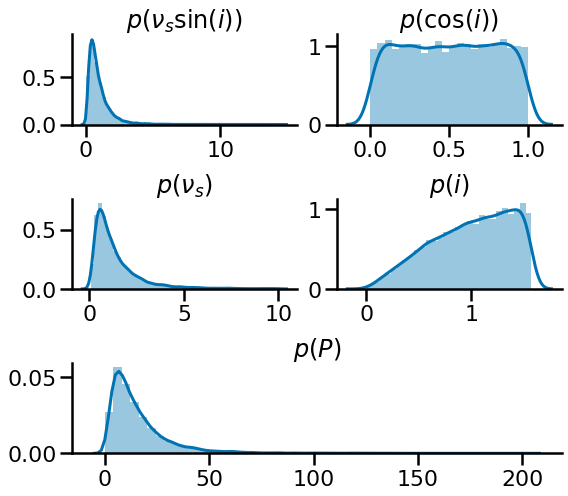

In [5]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(ax[0,0])
sns.distplot(xsplit, ax=ax0)
ax0.set_title(r'$p(\nu_s \sin(i))$')

ax1 = fig.add_subplot(ax[0,1])
sns.distplot(cosi, ax=ax1)
ax1.set_title(r'$p(\cos(i))$')

ax2 = fig.add_subplot(ax[1,0])
sns.distplot(split[split < 10], ax=ax2)
ax2.set_title(r'$p(\nu_s)$')

ax3 = fig.add_subplot(ax[1,1])
sns.distplot(i, ax=ax3)
ax3.set_title(r'$p(i)$')

ax4 = fig.add_subplot(ax[2,:])
sns.distplot(P, ax=ax4)
ax4.set_title(r'$p(P)$')

sns.despine()
fig.tight_layout()

plt.show()

## Let's check the location these priors take up in our data

In [62]:
ati = pd.read_csv('../../data/atium.csv',index_col=0)
ati = ati[ati.eye_flag != 3]
ati = ati[np.isfinite(ati.nus.values)]
ati.sort_values(by = 'age', inplace=True)
ati.reset_index(drop=True, inplace=True)
print(f'We have {len(ati)} stars with results right now.')

We have 94 stars with results right now.


## Let's check the vsin(i) near the prior limits as Jerôme suggested.

(0, 1.0615904915127183)

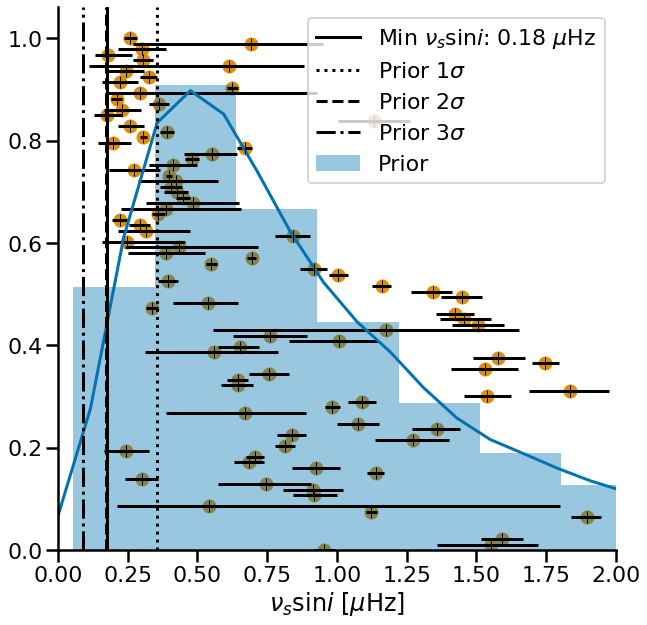

In [69]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(xsplit, label='Prior')
y = np.linspace(0, 1, len(ati))

plt.scatter(np.nan, np.nan)
plt.scatter(ati['nus*'], y)
plt.errorbar(ati['nus*'], y, xerr=[ati['l_nus*'], ati['u_nus*']], fmt='|', c='k')

plt.xlim(0, 2)
plt.axvline(ati['nus*'].min(), c='k', label=rf'Min $\nu_s\sini$: {ati["nus*"].min():.2f} $\mu$Hz')
l3, l2, l1 = np.nanpercentile(xsplit, [0.2, 2.3, 15.9])
plt.axvline(l1, c='k', ls=':', label=rf'Prior $1\sigma$')
plt.axvline(l2, c='k', ls='--', label=rf'Prior $2\sigma$')
plt.axvline(l3, c='k', ls='-.', label=rf'Prior $3\sigma$')           
plt.legend(loc='upper right')
plt.xlabel(r'$\nu_s\sini$ [$\mu$Hz]')
# plt.title(fr'Minimum $\nu_s$ measured: {ati["nus*"].min():.2f} $\mu$Hz')
sns.despine()
plt.xlim(0)
plt.ylim(0)

## Period

In [7]:
mnras_size(2*595)

[16.52777777777778, 10.214728425171874]

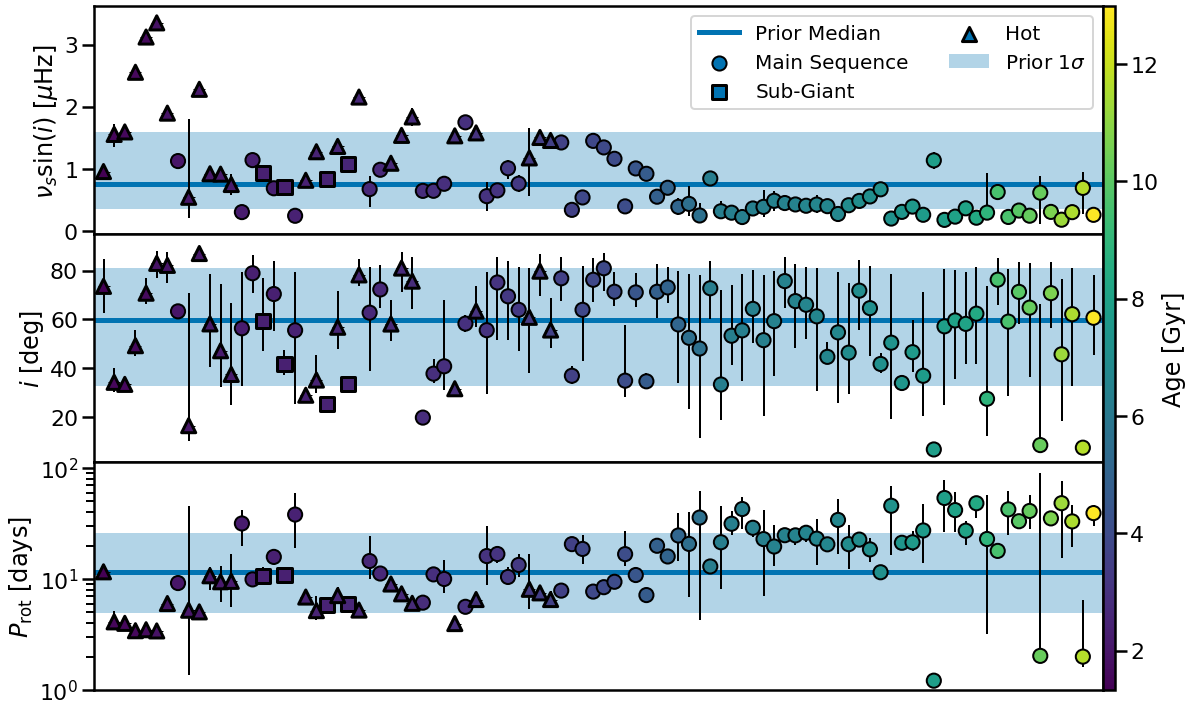

In [8]:
size = 200
ms = ati.hrclass == 'MS'
h = ati.hrclass == 'H'
sg = ati.hrclass == 'SG'
flag = ati.eye_flag > 0

#Period
l, m, u = np.percentile(P, [16., 50., 84])

fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
ax = axes[2]
y = np.linspace(0, 1., len(ati))
c = ax.scatter(y[ms],ati.P[ms], c=ati.age[ms], s=size, ec='k', lw=2, marker='o',zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())
c = ax.scatter(y[sg],ati.P[sg], c=ati.age[sg], s=size, ec='k', lw=3, marker=',', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())
c = ax.scatter(y[h],ati.P[h], c=ati.age[h], s=size, ec='k', lw=3, marker='^', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())

# c = ax.scatter(ati.P[flag], y[flag], s=size-50, c='r',  zorder=3)
ax.errorbar(y, ati.P, c='k', lw=2, yerr=[ati.l_P, ati.u_P], xerr=None, fmt='_', zorder=2)

ax.fill_between(np.linspace(-0.05, 1.05), l, u, zorder=0, alpha=.3, label='p(P)')
ax.axhline(m, zorder=1, lw=5)
ax.set_yscale('log')
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(1)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')

#Inclination
l, m, u = np.percentile(i, [16., 50., 84])

ax1 = axes[1]
y = np.linspace(0, 1, len(ati))
c = ax1.scatter(y[ms], np.rad2deg(ati.i[ms]),  c=ati.age[ms], s=size, ec='k', lw=2, marker='o',zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())
c = ax1.scatter(y[sg], np.rad2deg(ati.i[sg]),  c=ati.age[sg], s=size, ec='k', lw=3, marker=',', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())
c = ax1.scatter(y[h], np.rad2deg(ati.i[h]),  c=ati.age[h], s=size, ec='k', lw=3, marker='^', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max())

ax1.errorbar(y, np.rad2deg(ati.i), c='k', lw=2, yerr=[np.rad2deg(ati.l_i), np.rad2deg(ati.u_i)], xerr=None, fmt='_', zorder=2)

ax1.fill_between(np.linspace(-0.05, 1.05),np.rad2deg(l), np.rad2deg(u), zorder=0, alpha=.3, label='p(P)')
ax1.axhline(np.rad2deg(m), zorder=1, lw=5)

ax1.set_xlim(-0.01, 1.01)
ax1.set_ylabel(r'$i$ [deg]')

#Projected Splitting
l, m, u = np.percentile(xsplit, [16., 50., 84])

ax2 = axes[0]
y = np.linspace(0, 1, len(ati))
c = ax2.scatter(y[ms], ati['nus*'][ms], c=ati.age[ms], s=size, ec='k', lw=2, marker='o',zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max(), label='Main Sequence')
c = ax2.scatter(y[sg], ati['nus*'][sg], c=ati.age[sg], s=size, ec='k', lw=3, marker=',', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max(), label='Sub-Giant')
c = ax2.scatter(y[h], ati['nus*'][h], c=ati.age[h], s=size, ec='k', lw=3, marker='^', zorder=3,
                  vmin = ati.age.min(), vmax=ati.age.max(), label='Hot')

ax2.errorbar(y, ati['nus*'], c='k', lw=2, yerr=[ati['l_nus*'], ati['u_nus*']], xerr=None, fmt='_', zorder=2)

ax2.fill_between(np.linspace(-0.05, 1.05), l, u, zorder=0, alpha=.3, label=r'Prior $1\sigma$')
ax2.axhline(m, zorder=1, lw=5, label='Prior Median')

ax2.set_xlim(-0.01, 1.01)
ax2.set_ylabel(r'$\nu_s \sin(i)$ [$\mu$Hz]')



# ax.set_title(r'Rotation')
# ax2.set_title(r'Projected Asteroseismic Splitting')
# ax1.set_title(r'Angle of Inclination')
for a in axes:
    a.get_xaxis().set_visible(False)
    
ax2.legend(ncol=2, loc='upper right', fontsize=20)#,bbox_to_anchor=[0.0, 1.2, 1.01, 0.])
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.colorbar(c,label=r'Age [Gyr]', ax=axes.ravel(), pad=0, aspect=60)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/priors.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/priors.pdf', bbox_inches='tight', rasterized=True)

In [40]:
y[sg]

array([15., 17., 21., 23.])

In [41]:
ati[sg]

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
15,9592705,6174,2.3300,53.540,92,0.320,0.10,21.0,0.22,0.1600,...,0.052090,1.948601,10.733560,2.068692,0.808627,8.592304,0.799747,NaN,0,0.000416
17,10068307,6132,2.3616,53.945,77,0.019,0.10,2.8,-0.23,0.0958,...,0.034976,1.127130,10.869132,1.512842,0.301307,6.438744,0.283419,NaN,0,0.001167
21,10162436,6146,2.4574,55.725,77,0.035,0.10,4.0,-0.16,0.1118,...,0.045082,0.390903,5.881884,0.574150,0.479427,7.476930,0.444010,NaN,0,0.000939
23,5773345,6130,2.5533,57.303,84,0.030,0.09,5.7,0.21,0.2396,...,0.062993,0.508977,5.928397,0.707415,0.678823,9.502726,0.669663,NaN,0,0.000673


In [43]:
t = pd.read_csv('../../data/atium.csv',index_col=0)
t.loc[t.hrclass == 'SG']

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
9,5773345,6130,2.5533,57.303,84,0.030,0.09,5.7,0.21,0.2396,...,0.062993,0.508977,5.928397,0.707415,0.678823,9.502726,0.669663,NaN,0,0.000673
49,10068307,6132,2.3616,53.945,77,0.019,0.10,2.8,-0.23,0.0958,...,0.034976,1.127130,10.869132,1.512842,0.301307,6.438744,0.283419,NaN,0,0.001167
51,10162436,6146,2.4574,55.725,77,0.035,0.10,4.0,-0.16,0.1118,...,0.045082,0.390903,5.881884,0.574150,0.479427,7.476930,0.444010,NaN,0,0.000939
85,9592705,6174,2.3300,53.540,92,0.320,0.10,21.0,0.22,0.1600,...,0.052090,1.948601,10.733560,2.068692,0.808627,8.592304,0.799747,NaN,0,0.000416


In [34]:
ati

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
0,9139151,6302,1.3236,117.294,77,0.031,0.10,14.5,0.10,0.7506,...,0.026654,1.118586,11.611359,0.752346,0.195846,4.810897,0.197006,NaN,0,0.000768
1,9206432,6538,1.5312,84.926,77,0.046,0.10,10.3,0.16,0.3034,...,0.061284,0.518026,4.119384,1.045326,1.290188,10.245822,1.099605,NaN,0,0.000669
2,9139163,6400,1.5951,81.170,84,0.042,0.09,6.2,0.15,0.2236,...,0.061831,0.295394,3.992961,0.340728,0.531238,10.843906,0.493417,rhat_01,0,0.000905
3,11253226,6642,1.5951,76.858,77,0.026,0.10,10.6,-0.08,0.1278,...,0.047971,0.293906,3.428079,0.420729,0.834808,18.019642,0.756644,NaN,0,0.000847
4,2837475,6614,1.6270,75.729,77,0.041,0.10,8.2,0.01,0.1757,...,0.046604,0.154079,3.499114,0.172064,0.555348,22.351415,0.540087,NaN,0,0.000587
5,11081729,6548,1.8825,90.116,82,0.048,0.10,11.0,0.11,0.4152,...,0.053414,0.100527,3.413786,0.108467,0.620298,20.823592,0.610921,NaN,0,0.000773
6,6679371,6479,1.9464,50.601,77,0.029,0.10,5.1,0.01,0.1597,...,0.048306,0.217615,6.016980,0.216444,0.537566,18.345660,0.503919,NaN,0,0.000665
7,8379927,6067,1.9943,120.288,120,0.017,0.15,6.0,-0.10,0.7506,...,0.024722,0.234504,9.197603,0.254623,0.097586,5.500045,0.096390,NaN,0,0.000998
8,12069127,6276,2.0103,48.400,77,0.048,0.10,10.1,0.08,0.1278,...,0.054594,3.872275,5.242798,39.947151,3.309943,5.433056,12.633292,rhat_01,1,0.000416
9,6508366,6331,2.0582,51.553,77,0.046,0.10,4.6,-0.05,0.1437,...,0.047209,0.095520,5.065098,0.102414,0.421003,21.787564,0.410508,NaN,0,0.000946


It seems like $i$ is poorly constrained, which is expected. $\nu_s \sin(i)$ is the most tightly constrained, also as expected, and $P$ is for the most part well constrained after being subjected to the inclination angle probability function.

**Question**: Should we be concerned when we sample the priors in $i$, but not in $P$? How does this bias our results on $P$?